# Hydro-thermal power system planning problem: Deterministic Solution
The Brazilian interconnected power system has four regions, SE, S, N and NE, denoted by 0,1,2,3 for simiplicity.

In each region, there are one integrated reserviour and several thermal plants to provide energy. Energy exchange is allowed between regions and an additional transshipment station.

If demand can not be satisfied, a deficit cost will be incur.

The objective is to minimize the total cost over the designing period meanwhile meeting energy requirements and feasibility constraints.

Notation
--------

$v_{it}$: stored energy in subsystem (reservior) $i$ at the beginning of stage $t$  
$a_{it}$: energy inflow in subsystem $i$ during stage $t$   
$q_{it}$: turbined energy (hydro generation) in subsystem $i$ during stage $t$  
$s_{it}$: modelilled energy in subsystem $i$ during stage $t$  
$g_{kt}$: thermal generation at stage $t$ of thermal plants $k$ in each subsystem $i$ during stage $t$  
$\textrm{ex}_{i\rightarrow j,t}$: energy exchange from subsystem $i$ to subsystem $j$  
$\textrm{ex}_{j\rightarrow i,t}$: energy exchange from subsystem $j$ to subsystem $i$  
$\textrm{df}_{ijt}$: deficit account for subsystem $i$ in subsystem $j$ 

Formulation
----------------

Dynamics of each reservior $i$ is given by
$$v_{i,t+1} + s_{it} + q_{it} - v_{it} = a_{it}$$

Thermal plant generated energy and the hydro generated energy are the sources to satisfy demand. Energy can be exchanged between reserviors. Energy deficit will incur if demand can't be met. The supply-demand equation is thus
$$q_{it} + \sum_{k\in\omega_i} \textrm{g}_{kt} + \sum_{j} \textrm{df}_{ijt} -\sum_{j} \textrm{ex}_{i\rightarrow j,t} +\sum_{j} \textrm{ex}_{j\rightarrow i,t} = d_{it}$$

We assume there is no cost for hydro generation, $\$u_k$ for every megawatt thermal plant $k$ produces, $v_{ij}$ for every megawatt deficit account produces. Objective is to minimize energy generation cost (in thousands) over 12 months 

$$\sum_{t=1}^{12} \sum_i \big[\sum_k u_k g_{kt} + \sum_j v_{ij} \textrm{df}_{ijt}\big]$$

Deterministic solution
----------------

In [1]:
using CSV, DataFrames
using JuMP, Gurobi
using Plots

include("./HydroThermalVariables.jl")
using Main.HydroThermalVariables: thermal_ub, thermal_lb, thermal_obj, scenarios

In [2]:
hydro_ = DataFrame(CSV.File("./data/hydro.csv"))
hydro_ub = hydro_[9:12, 2]
storedEnergy_initial = hydro_[1:4, 3]
storedEnergy_ub = hydro_[1:4, 2]
inflow_initial = hydro_[5:8, 3];

deficit_ = DataFrame(CSV.File("./data/deficit.csv"))
deficit_obj = deficit_[:, 2]
deficit_ub = deficit_[:, 3];

exchange_ub = DataFrame(CSV.File("./data/exchange.csv"))[:, 2:end]
exchange_cost = DataFrame(CSV.File("./data/exchange_cost.csv"))[:, 2:end]

demand = DataFrame(CSV.File("./data/demand.csv"))[:, 2:end];

In [3]:
T = 120
sce = 1 # inflow scenario

m = Model(Gurobi.Optimizer)

@variable(m, 0 <= v[i=1:4,t=1:T] <= storedEnergy_ub[i]) # v - stored energy
@variable(m, 0 <= q[i=1:4,t=1:T] <= hydro_ub[i]) # q - hydro generation
@variable(m, thermal_lb[i][k] <= g[i=1:4,k=1:length(thermal_lb[i]),t=1:T] <= thermal_ub[i][k]) # g - thermal generation
@variable(m, 0 <= df[i=1:4,j=1:5,t=1:T] <= (demand[t%12==0 ? 12 : t%12,i]*deficit_ub[i])) # df - deficit account
@variable(m, 0 <= ex[i=1:5,j=1:5,t=1:T] <= exchange_ub[i,j]) # ex - energy exchange
@variable(m, s[i=1:4,t=1:T] >= 0) # s - spilled energy

for t=1:T
    ty = t%12==0 ? 12 : t%12
    
    for i=1:4
        if t==1
            @constraint(m, v[i,t]+s[i,t]+q[i,t]-storedEnergy_initial[i] == inflow_initial[i])
        else
            @constraint(m, v[i,t]+s[i,t]+q[i,t]-v[i,t-1] == scenarios[i][(t-1)%12==0 ? 12 : (t-1)%12][sce+div(t,12)])
        end
        @constraint(m, q[i,t]+sum(g[i,k,t] for k=1:length(thermal_lb[i]))+sum(df[i,j,t] for j=1:4)-
                    sum(ex[i,j,t] for j=1:5)+sum(ex[j,i,t] for j=1:5) == demand[ty,i])
    end
    @constraint(m, sum(ex[j,5,t] for j=1:4) == sum(ex[5,j,t] for j=1:4))
end

@objective(m, Min, sum(sum(sum(exchange_cost[j,i]*ex[j,i,t] for j=1:5)+
                           sum(thermal_obj[i][k]*g[i,k,t] for k=1:length(thermal_obj[i]))+
                           sum(deficit_obj[i]*df[i,j,t] for j=1:4) for i=1:4)+
                        sum(exchange_cost[j,5]*ex[j,5,t] for j=1:4) for t=1:T)
          )

m

Academic license - for non-commercial use only - expires 2022-01-02


A JuMP Model
Minimization problem with:
Variables: 18240
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 1080 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 18240 constraints
`VariableRef`-in-`MathOptInterface.LessThan{Float64}`: 17760 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Gurobi
Names registered in the model: df, ex, g, q, s, v

In [4]:
optimize!(m)

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1080 rows, 18240 columns and 20516 nonzeros
Model fingerprint: 0x0e4d0593
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-04, 6e+03]
  Bounds range     [7e-01, 2e+05]
  RHS range        [1e+03, 1e+05]
Presolve removed 25 rows and 6637 columns
Presolve time: 0.02s
Presolved: 1055 rows, 11603 columns, 13709 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.9409910e+07   3.636331e+05   0.000000e+00      0s
    1008    5.2286347e+08   0.000000e+00   0.000000e+00      0s

Solved in 1008 iterations and 0.04 seconds
Optimal objective  5.228634660e+08

User-callback calls 1051, time in user-callback 0.00 sec


In [5]:
objective_value(m)

5.228634659708033e8

## Compare different scenarios

We have inflow data from $82$ years.

Given that we analyze $120$ months ($10$ years), there are $72*12$ different starting points.

In [6]:
obj_values = [];

In [7]:
for t_init=0:72*12-1

    m = Model(Gurobi.Optimizer)

    @variable(m, 0 <= v[i=1:4,t=1:T] <= storedEnergy_ub[i]) # v - stored energy
    @variable(m, 0 <= q[i=1:4,t=1:T] <= hydro_ub[i]) # q - hydro generation
    @variable(m, thermal_lb[i][k] <= g[i=1:4,k=1:length(thermal_lb[i]),t=1:T] <= thermal_ub[i][k]) # g - thermal generation
    @variable(m, 0 <= df[i=1:4,j=1:5,t=1:T] <= (demand[t%12==0 ? 12 : t%12,i]*deficit_ub[i])) # df - deficit account
    @variable(m, 0 <= ex[i=1:5,j=1:5,t=1:T] <= exchange_ub[i,j]) # ex - energy exchange
    @variable(m, s[i=1:4,t=1:T] >= 0) # s - spilled energy

    for t=1:T
        t_up = t+t_init
        ty = t%12==0 ? 12 : t%12
        
        for i=1:4
            if t==1
                @constraint(m, v[i,t]+s[i,t]+q[i,t]-storedEnergy_initial[i] == inflow_initial[i])
            else
                @constraint(m, v[i,t]+s[i,t]+q[i,t]-v[i,t-1] == scenarios[i][(t_up-1)%12==0 ? 12 : (t_up-1)%12][div(t_up,12)+1])
            end
            @constraint(m, q[i,t]+sum(g[i,k,t] for k=1:length(thermal_lb[i]))+sum(df[i,j,t] for j=1:4)-
                        sum(ex[i,j,t] for j=1:5)+sum(ex[j,i,t] for j=1:5) == demand[ty,i])
        end
        @constraint(m, sum(ex[j,5,t] for j=1:4) == sum(ex[5,j,t] for j=1:4))
    end

    @objective(m, Min, sum(sum(sum(exchange_cost[j,i]*ex[j,i,t] for j=1:5)+
                            sum(thermal_obj[i][k]*g[i,k,t] for k=1:length(thermal_obj[i]))+
                            sum(deficit_obj[i]*df[i,j,t] for j=1:4) for i=1:4)+
                            sum(exchange_cost[j,5]*ex[j,5,t] for j=1:4) for t=1:T)
            )
    optimize!(m);

    append!(obj_values, objective_value(m));
end;

Academic license - for non-commercial use only - expires 2022-01-02
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1080 rows, 18240 columns and 20516 nonzeros
Model fingerprint: 0x0e4d0593
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-04, 6e+03]
  Bounds range     [7e-01, 2e+05]
  RHS range        [1e+03, 1e+05]
Presolve removed 25 rows and 6637 columns
Presolve time: 0.02s
Presolved: 1055 rows, 11603 columns, 13709 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.9409910e+07   3.636331e+05   0.000000e+00      0s
    1008    5.2286347e+08   0.000000e+00   0.000000e+00      0s

Solved in 1008 iterations and 0.05 seconds
Optimal objective  5.228634660e+08

User-callback calls 1051, time in user-callback 0.00 sec
Academic license - for non-commercial use only - expires 2022-01-02
Gurobi Optimizer version 9.1.2

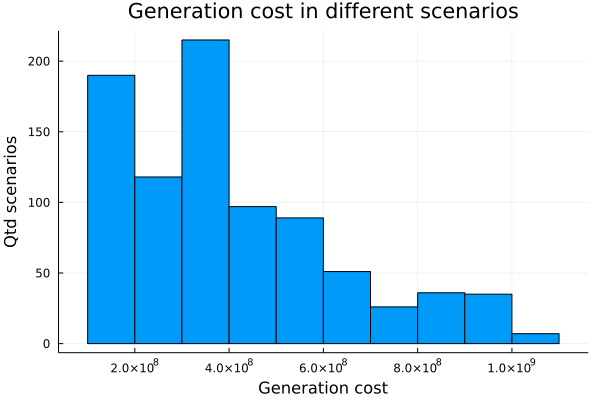

In [8]:
histogram(obj_values, title = "Generation cost in different scenarios", legend=false)
ylabel!("Qtd scenarios")
xlabel!("Generation cost")

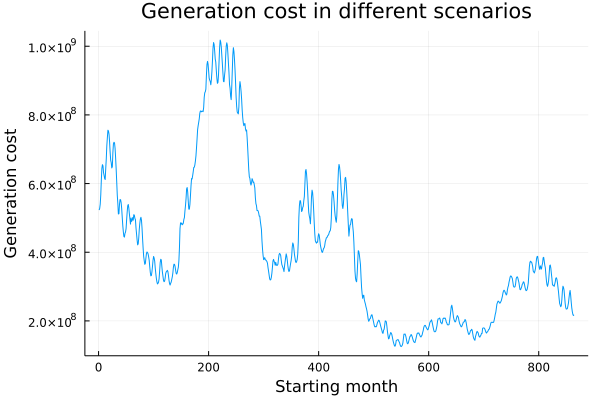

In [9]:
plot(obj_values, title = "Generation cost in different scenarios", legend = false)
xlabel!("Starting month")
ylabel!("Generation cost")